Import the necessary python modules

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import warnings
warnings.filterwarnings('ignore') # supress warnings
import time
import calendar

from datetime import datetime
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

Import the training and test data set

In [ ]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

**Numeric Exploratory Data Analysis**

In [ ]:
type(train_data)

In [ ]:
train_data.head()

In [ ]:
train_data.shape

In [ ]:
train_data.info()

In [ ]:
test_data.shape

In [ ]:
test_data.info()

In [ ]:
train_data.isnull().sum()

In [ ]:
test_data.isnull().sum()

**Visual Exploratory Data Analysis**

Visualizing the Distribution of Data

In [ ]:
ax1 = plt.subplot(221)
sns.distplot(train_data["count"])
ax2 = plt.subplot(222)
stats.probplot(train_data["count"], dist='norm', fit=True, plot=plt)

**Feature Generation**

In [ ]:
# Derive features from datetime column
train_data["date"] = train_data.datetime.apply(lambda x : x.split()[0])
train_data["hour"] = train_data.datetime.apply(lambda x : x.split()[1].split(":")[0])
train_data["weekday"] = train_data.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
train_data["month"] = train_data.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
train_data["year"] = train_data.datetime.apply(lambda x : x.split()[0].split("-")[0])

In [ ]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,20)

monthAggregated = pd.DataFrame(train_data.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
sns.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(train_data.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(train_data.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(train_data[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

**Encoding Categorical Features**

In [ ]:
# Group categorical columns into a dictionary
featureCatCols = ['season','holiday','workingday','weather']
derivedCatcols = ['hour','weekday','month','year']
featureCatCols = featureCatCols + derivedCatcols
dfFeatureCat = train_data[featureCatCols]
# Transpose index & columns and convert it to dictionary
dictFeatureCat = dfFeatureCat.T.to_dict().values()

# Vectorize categorical features
vec = DictVectorizer(sparse = False)
vec_cat = vec.fit_transform(dictFeatureCat)

# Encode categorical features
enc = OneHotEncoder()
enc.fit(vec_cat)
vec_cat = enc.transform(vec_cat).toarray()

In [ ]:
# Group non-categorical columns into a dictionary
featureConCols = ['temp','atemp','humidity','windspeed']
dfFeatureCon = train_data[featureConCols]
dictFeatureCon = dfFeatureCon.T.to_dict().values()

# Vectorize non categorical features
vec = DictVectorizer(sparse = False)
vec_con = vec.fit_transform(dictFeatureCon)

In [ ]:
# Combine categorical and non-categorical all features
X = np.concatenate((vec_con,vec_cat), axis=1)

**Train/Test Split**

In [ ]:
y = train_data["casual"]
y_registered = train_data["registered"]
y_count = train_data["count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


**Model Training, Prediction & Evaluation**

**Evaluation** [https://www.kaggle.com/c/bike-sharing-demand#evaluation](http://)

Formula to compute RMSLE 
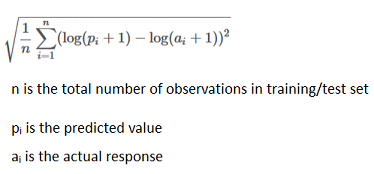

Define Root Mean Square Logarithmic Error

In [ ]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(p + 1) for p in y]))
    log2 = np.nan_to_num(np.array([np.log(a + 1) for a in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [ ]:
# Linear Regression
linreg = LinearRegression()
# Train the model
linreg.fit(X=X_train, y=np.log1p(y_train))
# Test the model
y_pred = linreg.predict(X=X_test)
print ("RMSLE Value: ", rmsle(y_test, np.exp(y_pred)))


In [ ]:
# Ridge Regression
ridge = Ridge()
ridge_params = {'max_iter':[3000],'alpha':[0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000]}
grid_ridge = GridSearchCV(ridge, ridge_params, cv=5)
grid_ridge.fit(X_train, np.log1p(y_train))
y_pred = grid_ridge.predict(X=X_test)
print (grid_ridge.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(np.log1p(y_test)),np.exp(y_pred)))

In [ ]:
# Lasso Regression
lasso = Lasso()
alpha = [0.001,0.005,0.01,0.3,0.1,0.3,0.5,0.7,1]
lasso_param_grid = {'alpha':alpha, 'max_iter':[500]}
grid_lasso = GridSearchCV(lasso, lasso_param_grid, cv=5)
grid_lasso.fit(X=X_train,y=np.log1p(y_train))
y_pred = grid_lasso.predict(X=X_test)
print (grid_lasso.best_params_)
print ("RMSLE Value: ", rmsle(y_test,np.exp(y_pred)))

In [ ]:
# Feature importance by Lasso Regression
lasso = Lasso(alpha=0.001, max_iter=500)
lasso.fit(X=X_train,y=np.log1p(y_train))
lasso.predict(X=X_test)
print(lasso.coef_)

In [ ]:
# Random Forest Regression
start_time = time.time()
rfreg = RandomForestRegressor()
param_grid = {'n_estimators': np.arange(40, 50)}
grid_random_forest = GridSearchCV(rfreg, param_grid, cv=5)
grid_random_forest.fit(X=X_train, y= np.log1p(y_train))
y_pred = grid_random_forest.predict(X=X_test)
elapsed_time = time.time() - start_time
print("elapsed time", elapsed_time, "seconds")
print("best params", grid_random_forest.best_params_)
print("RMSLE Value: ", rmsle(y_test,np.exp(y_pred)))

In [ ]:
# Compute feature importances by random forest
rfreg = RandomForestRegressor(n_estimators=47)
rfreg.fit(X=X_train, y= np.log1p(y_train))
y_pred = rfreg.predict(X=X_test)
importances = rfreg.feature_importances_
print(importances)

In [ ]:
# Gradient Boost Regression
start_time = time.time()
gbreg = GradientBoostingRegressor()
param_grid = { 
    'n_estimators': [1000],
    'learning_rate':[0.1,0.01,0.001]
    #'max_features': ["auto","sqrt","log2"],
    #'max_depth' : [3,4,5,6,7,8]    
}
CV_gbreg = GridSearchCV(estimator=gbreg,param_grid=param_grid,cv=5)
CV_gbreg.fit(X=X_train,y=np.log1p(y_train))
print(CV_gbreg.best_params_)
y_pred = CV_gbreg.predict(X=X_test)
elapsed_time = time.time() - start_time
print("elapsed time", elapsed_time, "seconds")
print ("RMSLE Value: ", rmsle(y_test,np.exp(y_pred)))